In [26]:
import kagglehub
import struct
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from array import array
from os.path  import join
from torch.utils.data import TensorDataset, DataLoader

In [27]:
#
# MNIST Data Loader Class from https://www.kaggle.com/code/hojjatk/read-mnist-dataset
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

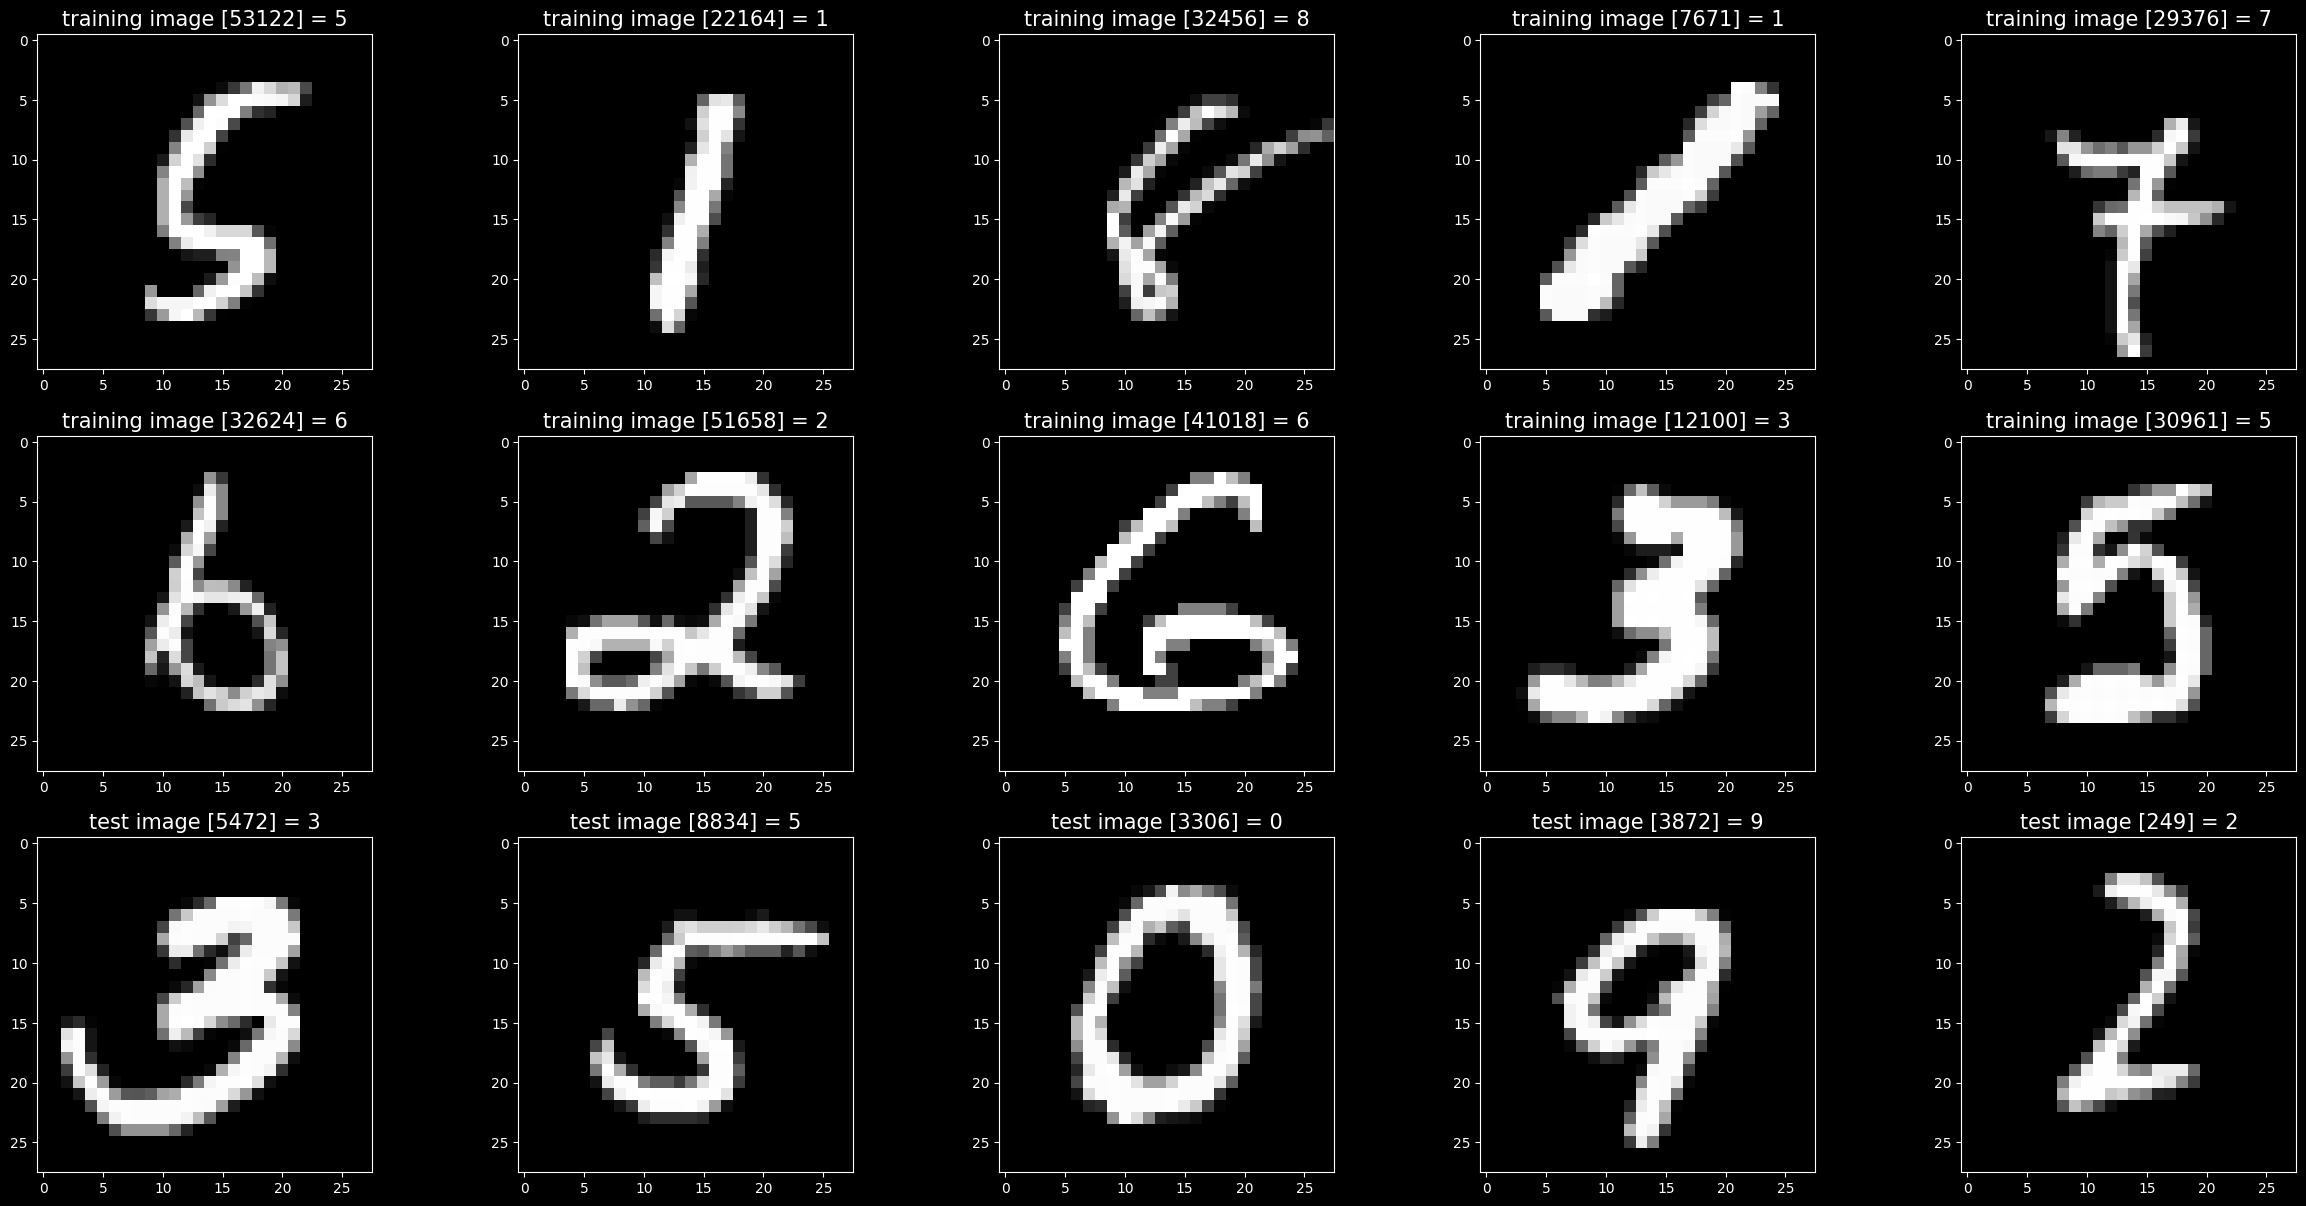

In [28]:
#
# Verify Reading Dataset via MnistDataloader class (reference: https://www.kaggle.com/code/hojjatk/read-mnist-dataset)
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = kagglehub.dataset_download("hojjatk/mnist-dataset")
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [29]:
# 1. init random weights
# 2. loop:
#     2a. predict
#     2b. loss function
#     2c. gradient
#     2d. update weights

# 0. create dataset
def create_data_loader(x, y):
    x_train_np = np.array(x)
    y_train_np = np.array(y)

    # flatten and normalize input data
    x_train_tensor = torch.tensor(x_train_np).float().view(-1, 28 * 28) / 255.0
    y_train_tensor = torch.tensor(y_train_np).long()

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # create batches for sgd
    batch_size = 64
    return DataLoader(train_dataset, batch_size, True)

train_loader = create_data_loader(x_train, y_train)

# 1. params, bias, and activation functions
net = nn.Sequential(
    nn.Linear(28 * 28, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 10)
)

# optimizer
opt = optim.Adam(net.parameters(), lr=0.001)

# criterion
criterion = nn.CrossEntropyLoss()
loss = None

# 2. loop
epochs = 20
for epoch in range(epochs):
    for images, labels in train_loader:
        # 2a. predict
        y_pred = net(images)
        # 2b. loss function
        loss = criterion(y_pred, labels)
        # 2c. gradient
        opt.zero_grad()
        loss.backward()
        # 2d. update weights
        opt.step()
    print(f"Epoch {epoch+1} complete. Loss: {loss.item():.4f}")

Epoch 1 complete. Loss: 0.2541
Epoch 2 complete. Loss: 0.1454
Epoch 3 complete. Loss: 0.0274
Epoch 4 complete. Loss: 0.0018
Epoch 5 complete. Loss: 0.2099
Epoch 6 complete. Loss: 0.1233
Epoch 7 complete. Loss: 0.0112
Epoch 8 complete. Loss: 0.0001
Epoch 9 complete. Loss: 0.0003
Epoch 10 complete. Loss: 0.0070
Epoch 11 complete. Loss: 0.0308
Epoch 12 complete. Loss: 0.0013
Epoch 13 complete. Loss: 0.0778
Epoch 14 complete. Loss: 0.0056
Epoch 15 complete. Loss: 0.0178
Epoch 16 complete. Loss: 0.1024
Epoch 17 complete. Loss: 0.0001
Epoch 18 complete. Loss: 0.0150
Epoch 19 complete. Loss: 0.0173
Epoch 20 complete. Loss: 0.0002


In [30]:
# validate results
net.eval()

test_loader = create_data_loader(x_test, y_test)

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"{correct} correct out of {total}")

9818 correct out of 10000
